### Research Process 


#### Init Libraries

In [1]:
import pandas as pd
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import os

#### Load Dataset and split into Features and Label

In [2]:
#load data
df=pd.read_csv("breast-cancer-wisconsin-data/data.csv")
#drop irelevent columns for the classification
df = df.drop(columns=['Unnamed: 32', 'id'])
# rearange the data for X - featuers and Y leabels 
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

#### Encode Labels

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)

#### The mapping of the labels

In [4]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'B': 0, 'M': 1}


#### Splitting the data into Train, Test and Valid datasets

In [5]:
#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Scale the data

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#### Handling the imbalance between the classes

In [7]:
#handling imbalance data 
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
#the class weight is done only on the train data to impact the learning process and to evaluete beter the model proformence
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.7878787878787878, 1: 1.368421052631579}

as predicted the minorty class 'M'=1 gets higher weight of 1.368

### Neural Networks

##### Init Libraries

In [8]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.regularizers import l1, l2
#from keras.layers import Dropout, Flatten, BatchNormalization
from keras import models
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks
from keras import utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf

##### Function Helpers

In [9]:
def model_result(model):
    print('================================================================================')
    print(f'Evaluation Report for Model: {model.name}')

    # accuracy
    result = model.evaluate(X_test, y_test, verbose=0)        
    print(f'Loss Value: {result[0]:.3f}, Accuracy: {result[1]*100:.3f}%')

    # confusion matrix
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.round(y_prob).astype(int)    
    cm_test = confusion_matrix(y_test, y_pred)    
    #sns.heatmap(cm_test,annot=True)
    cm_disp = ConfusionMatrixDisplay(cm_test, display_labels=le.classes_)
    cm_disp.plot()
    plt.show()

    # classification report
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print(report)

    print('Model Summary:')
    print(model.summary())
    print('================================================================================')

In [10]:
def model_history(history):
    plt.figure(figsize=(15,6))

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.plot(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], 'r*', label='Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_loss'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_loss'][val_loss_min_pos]:.3f})', va='bottom')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], 'r*', label='Validation Accuracy @ Min Validation Loss')
    plt.text(val_loss_min_pos, history.history['val_accuracy'][val_loss_min_pos], f'({val_loss_min_pos}, {history.history['val_accuracy'][val_loss_min_pos]:.3f})', va='bottom')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()    

In [11]:
def proc_history(history):

    val_loss_min_pos = np.argmin(history.history['val_loss'])

    train_acc = history.history['accuracy'][val_loss_min_pos]
    train_loss = history.history['loss'][val_loss_min_pos]

    val_acc = history.history['val_accuracy'][val_loss_min_pos]
    val_loss = history.history['val_loss'][val_loss_min_pos]

    return {'Train Accuracy': train_acc, 'Train Loss': train_loss, 'Validation Accuracy': val_acc, 'Validation Loss': val_loss}

In [34]:
def model_fit(model, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, pca=False, verbose="auto", Dataset=None):      
    
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=0)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=0)
    checkpoint_filepath = f'model_checkpoints/{model.name}_checkpoint.model.keras'
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0)
    
    callbacks_list = [model_checkpoint_callback]

    if en_reduce_lr:
        callbacks_list.append(reduce_lr)

    if en_early_stopping:
        callbacks_list.append(early_stopping)

    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    if Dataset is None:
        history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epochNum, validation_data=(X_val, y_val), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)
    else:
        history = model.fit(Dataset['X_train'], Dataset['y_train'], batch_size=batchSize, epochs=epochNum, validation_data=(Dataset['X_val'], Dataset['y_val']), class_weight=class_weight_dict, callbacks=callbacks_list, verbose=verbose)

    model = models.load_model(checkpoint_filepath)

    return history, model

In [41]:
def model_kfold(xtrain, ytrain, model_base, epochNum=1000, batchSize=32, verbose="auto"):
    model = models.clone_model(model_base)
    fold_k = StratifiedKFold(n_splits = 20).split(xtrain, ytrain)
    xtrain_f, xvalid_f,ytrain_f, yvalid_f = [], [], [], []
    result_df = pd.DataFrame(columns=['k', 'Train Accuracy', 'Train Loss' , 'Validation Accuracy', 'Validation Loss'])
    for k , (train, valid) in enumerate(fold_k):
        xtrain_f.append(xtrain[train]), xvalid_f.append(xtrain[valid])
        ytrain_f.append(ytrain[train]), yvalid_f.append(ytrain[valid])
        dataset = {'X_train': xtrain[train], 'y_train': ytrain[train], 'X_val': xtrain[valid], 'y_val': ytrain[valid]}
        model.set_weights(model_base.get_weights())
        history, model = model_fit(model, epochNum=1000, batchSize=32, en_reduce_lr=False, en_early_stopping=True, Dataset=dataset, verbose=verbose)    
        
        train_res = model.evaluate(xtrain[train], ytrain[train], verbose=verbose)
        val_res = model.evaluate(xtrain[valid], ytrain[valid], verbose=verbose)

        new_row = {'k': k, 'Train Accuracy': train_res[1], 'Train Loss': train_res[0], 'Validation Accuracy': val_res[1], 'Validation Loss': val_res[0]}

        result_df.loc[len(result_df)] = new_row

    return result_df

##### Build the model

In [14]:
models_list = []

### SLP

In [15]:
# deterministic fitting   
os.environ['PYTHONHASHSEED']=str(0)
utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()  

#### Baseline

In [16]:
CURRENT_MODEL = models.Sequential(name=f'SLP_1')

CURRENT_MODEL.add(layers.Input((30,)))
CURRENT_MODEL.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model = models.clone_model(CURRENT_MODEL)
model.set_weights(CURRENT_MODEL.get_weights())

##### Baseline - Results

In [18]:
history, model = model_fit(model, epochNum=1000, batchSize=32, verbose=0)

proc_data = proc_history(history)

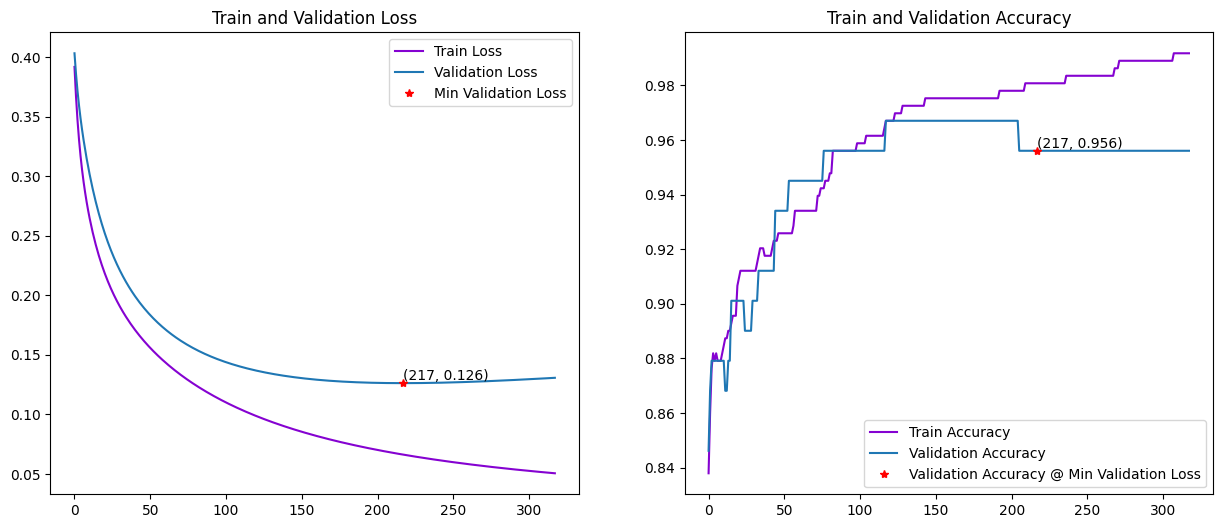

In [19]:
model_history(history)

In [42]:
model.set_weights(CURRENT_MODEL.get_weights())

res_df = model_kfold(X_train, y_train, model, epochNum=1000, batchSize=32, verbose=0)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.9902 - loss: 0.0308
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0278
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.9965 - loss: 0.0301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9474 - loss: 0.1357
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.9902 - loss: 0.0324
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0286
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.9891 - loss: 0.0377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0237
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9902 - loss: 0.0301
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0245
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9902 - loss: 0.0312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0075
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9902 - loss: 0.0316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc

#### Batch-Size

In [ ]:
df_batch_size = pd.DataFrame(columns=['Batch Size', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss'])

for batch_size in [1, 2, 4, 8, 16, 32, 64, 128]:
    print(f'------------------------------------------------------------------------------------------------------------------')
    print(f'Batch Size = {batch_size}')    
        
    model.set_weights(CURRENT_MODEL.get_weights())   

    history, model = model_fit(model, epochNum=1000, batchSize=batch_size, en_early_stopping=True, verbose=0)
    proc_data = proc_history(history)
    
    new_row = {'Batch Size': batch_size, **proc_data}
    df_batch_size.loc[len(df_batch_size)] = new_row
    model_history(history)
